# Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction. 

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment3_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 8 extra credit. 

# Answers to the theoretical questions 
Please provide your answers to questions 1-3 here.

(20 points total)



**Answer to Q1**
**You are assigned the task to produce land cover maps over a diverse area. You are specifically given a Landsat-8 imagery of 15000x8000 pixels resampled to 15 meters. You are using bands 1-7, plus a DEM and derived slope raster layers as extra bands. For good measures you also produce and add 6 more spectral indices as extra layers which gives you in total 15 input bands. land cover categories are as follows:

{0:"unknown", 1:"forest", "2:"grassland", 3:"cultivated land", 4:"build-up areas", 5:"Water"}

You are provided with 10000 annotated examples for each land cover category for the purpose of training. And your employer wants to first test an MLP with a single hidden layer will be used as the model.

**a) How would you proceed with this prediction task? 

What is your input to the model? What is the shape of the input in tensor form?

What do you think is a good choice for the number of units in our single hidden layer? What is the shape of the weight and bias matrices? (5 points)** 

- The input to the model will be a 3D tensor in the shape of 15000x8000x15.

- For the single hidden layer, a good choice for the number of units would be 512. This should provide a good balance between model complexity and accuracy. The shape of the weight and bias matrices would be (21x512, 512x1).

Another way of calculating this is to use the formula 
Nh= Ns/a(Ni+No)

where Nh is the number of neurons

Ns is the number of training samples available (10,000)

Ni= input parameters (15)

and No is output parameters. (6)

a (alpha) is a hyperparameter that can be optimized in order to find the right balance between generalizing and overfitting, typicall between 2 and 10. 

Using the lower end of alpha, 2, we would get

10,000/2(21)= 238. Any higher alpha would produce a lower number of neurons which seems too low. 



**b) Seeing how talented you are, your employer asks for a fancy CNN model to be used. Given the data you have available, how can we achieve a dense prediction with a conventional CNN you played with in the second assignment? If it’s doable, how would you shape your input? (5 points)**


While it is possible to achieve dense prediction using a conventional CNN, it may not be the most effective approach, especially for tasks such as semantic segmentation or depth estimation where the output should have the same dimensions as the input.

The input to a CNN is typically a tensor of shape (batch_size, channels, height, width), where batch_size is the number of input examples, channels is the number of input channels (e.g., 3 for RGB images), height is the height of the input image, and width is the width of the input image.

To achieve dense prediction, the input tensor must have the same spatial dimensions as the desired output. For example, if you want to perform semantic segmentation on an input image of size 512x512, the output should also have dimensions 512x512. In this case, the input tensor would have a shape of (batch_size, channels, 512, 512).

It's worth noting that when working with larger images, the memory requirements of the CNN can become a limiting factor. One way to address this is to use a technique called "patch-based processing", where the input image is divided into smaller overlapping patches, and the CNN is applied to each patch independently. The outputs are then combined to generate the final dense prediction for the entire image.


**Answer to Q2**

What are the benefits of only using convolution layers in a CNN architecture? 

1. One advantage to using convolution layers instead of fully connected neural networks is that they are more efficient, and take fewer parameters, because they share weights among multiple neurons.

2. Another advantage of convolutoinal layers is their ability to better extract localized features from input data, making them better suited for analyzing spatial relationships. 

3. They are also better at generalization, because they have fewer parameters, and are less likely to overfit, making them better for image classification. 



**Answer to Q3**
What's the main lesson learned from the design of decoder head in FCN-32, FCN-16 and FCN-8 architectures?

The lesson learned here is that multilayer decoding has advantages-- additional layers mean additional parameters which allow the network to better learn relationships between data. 
Also, we can say that transposed convolution is superior to bilinear upsampling, which simply inputs zero values between existing pixels, as opposed to transposed convolution, which uses a filter to interpolate values between the existing elements of an input. 





---


# **Practical starts from Here**

---





In [74]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
%%capture
!pip install rasterio

In [76]:
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
import rasterio
import cv2
import random
import math
import numbers
from pathlib import Path
from scipy.ndimage import rotate
from scipy.ndimage import shift

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from IPython.core.debugger import set_trace

## Coding Assignment 1 

10 points total

In all code cells below change "your_model_name" with the name you choose for your model. My recommendation: "unet" + "_" + "your initial".

In [77]:
class unet_jpa(nn.Module):
    def __init__(self, n_classes, in_channels, filter_config=(64, 128, 256, 512, 1024), dropout_rate=0):
        super(unet_jpa, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, filter_config[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[0], filter_config[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(filter_config[0], filter_config[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[1], filter_config[1], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(filter_config[1], filter_config[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[2], filter_config[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[2], filter_config[2], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(filter_config[2], filter_config[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[3], filter_config[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[3], filter_config[3], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(filter_config[3], filter_config[4], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[4], filter_config[4], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_config[4], filter_config[4], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(filter_config[4] * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(4096, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        output_logits=self.classifier(x)
        return output_logits

### Show your work

To test if you got it right lets initialize our model and print it.

In [78]:
n_classes = 2
in_channels = 6
filter_config = (64, 128, 256, 512, 1024) 
dropout_rate = 0.15

In [79]:
model=unet_jpa(n_classes, in_channels, filter_config, dropout_rate)

In [80]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 253,547,522 trainable parameters


In [81]:
print(model)

unet_jpa(
  (features): Sequential(
    (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

## Coding assignment 2 

20 points total

### Static code

In [82]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation 
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below. 

In [83]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [84]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

#### Chipping

In [210]:
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "validate"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size, 
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size, 
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validate") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "validate":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Helper functions

Code for plotting images.  You will use these to demonstrate your work. 

In [211]:
#@title Plot RGB composite or single band image

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image 
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)
    
    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array
        
        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

In [212]:
#@title Plot RGB composite and label pair

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image_and_label(image_array, label_array, band_composite=None, 
                         stretch=None):
    r"""
    Plots a loaded image and its corresponding label using matplotlib and 
    rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        label_array (numpy.ndarray) : A numpy array containing label data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)
    
    image_size=[image_array.shape[0], image_array.shape[1]]
    label_size=[label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1]
    green_band = image_array[:, :, band_composite[1] - 1]
    blue_band = image_array[:, :, band_composite[2] - 1]

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)
    
    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    axs[0].axis('off')

    # Plot label chip
    axs[1].imshow(label_array, cmap='viridis')
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Show the plot
    axs[1].axis('off')
    plt.show()

In [213]:
#@title Plot random patches from the Pytorch customDataset object.

import numbers
import matplotlib.pyplot as plt

def show_random_patches(dataset, sample_num, rgb_bands=(4, 5, 3)):
    """
    Plots a user-defined number of image chips and the corresponding labels.
    Arguments:
    dataset (AquacultureData object) : Loaded custom dataset.
    sample_num (int) : Number of pairs of image chips and their corresponding 
        labels to be plotted.
    rgb_bands (tuple of int) : List of the rgb bands for visualization indexed 
        from zero.
    Note: The order of the input bands is as follows:
          bands = {0 : "Landsat band 2 (Blue)",
                   1 : "Landsat band 3 (Green)",
                   2 : "Landsat band 4 (Red)",
                   3 : "Landsat band 5 (NIR)",
                   4 : "Landsat band 6 (SWIR 1)",
                   5 : "Landsat band 7 (SWIR 2)"}
    """
    # Because train_dataset does dynamic augmentation, we first make a deep copy 
    # of it before ploting.
    static_dataset = list(dataset)

    if ((isinstance(rgb_bands, tuple) or isinstance(rgb_bands, list)) and
            (len(rgb_bands) == 3) and
            (isinstance(rgb_bands[0], numbers.Number) and
             isinstance(rgb_bands[1], numbers.Number) and
             isinstance(rgb_bands[2], numbers.Number)) and
            ((sample_num is not None) and 
             (1 <= sample_num <= len(static_dataset)))):
        r = rgb_bands[0]
        g = rgb_bands[1]
        b = rgb_bands[2]

        nrow = sample_num
    else:
        del static_dataset
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")

    # Randomly select as many patches as the user defined for plotting.
    sample_index = []
    ncol = 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, nrow * 16 / 2), 
                            squeeze=False)

    for index in range(sample_num):
        sample_index.append(random.randrange(len(static_dataset)))

    viewSize = static_dataset[sample_index[0]][1].shape

    for i in range(sample_num):
        b_r = static_dataset[sample_index[i]][0][r,:,:].cpu().view(1, *viewSize)
        b_g = static_dataset[sample_index[i]][0][g,:,:].cpu().view(1, *viewSize)
        b_b = static_dataset[sample_index[i]][0][b,:,:].cpu().view(1, *viewSize)

        if (b_r.max() - b_r.min()) > 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0).int()

        elif 0 <= (b_r.max() - b_r.min()) <= 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0)

        axs[i, 0].set_title('Image Patch #{}'.format(sample_index[i]))
        axs[i, 0].imshow(rgb)
        axs[i, 1].set_title('Label Patch #{}'.format(sample_index[i]))
        axs[i, 1].imshow(static_dataset[sample_index[i]][1])

    plt.show()
    del static_dataset

### Coding Tasks

Modify the code below here to complete the second coding assignment. 

#### Load the dataset
Let's first make ourselves familiar with our dataset, using `rasterio`. 

Note that we're not passing any arguments to `src.read()` since we want to read all bands of the image. If you want to read a specific band, you can pass the band number as an argument (e.g. `src.read(3)` to read the third band).

First we load the imagery. The image source is kept in a csv catalog that will provides the file name and path for the label image, the mask image, and the Landsat image. There are set of these for each training and validation. Let's have a look. 

In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
# Define the path to the catalog in Google Drive (shared with you). 
# Modify it as needed to match your Drive structure. 
# you may find it helpful to define a variable that contains the path root 
# (src_dir)
src_dir = "/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data"
csv_name = "pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))
catalog

,country,region,wrs_path,wrs_row,year,usage,img_dir,label_dir,mask_dir
0,indonesia,indramayu,121,64,2014,train,clip_tile_121_64/bands/comp456_2014_clip_121_6...,clip_tile_121_64/label/ponds_2014_clip_121_64.rst,clip_tile_121_64/mask/mask_2014_clip_121_64.rst
1,indonesia,jakarta,122,64,2014,validate,clip_tile_122_64/bands/comp456_2014_clip_122_6...,clip_tile_122_64/label/ponds_2014_clip_122_64.rst,clip_tile_122_64/mask/mask_2014_clip_122_64.rst


Now let's use those directory paths in the csv to read in and display the imagery, label, and mask for the training path. 

In [216]:
# Define the path to the image file in Google Drive
img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image_array = src.read()
    image_array = image_array.transpose(1,2,0)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


Let's get the labels

In [217]:
# Define the path to the label file in Google Drive
lbl_path = os.path.join(src_dir, 
                        catalog[catalog.usage=='train']['label_dir'][0])

with rasterio.open(lbl_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    lbl_array = src.read(1)

{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


In [218]:
lbl_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Let's visualize the image and labels. Note that you can change the order of the 3 bands for different renderings. 

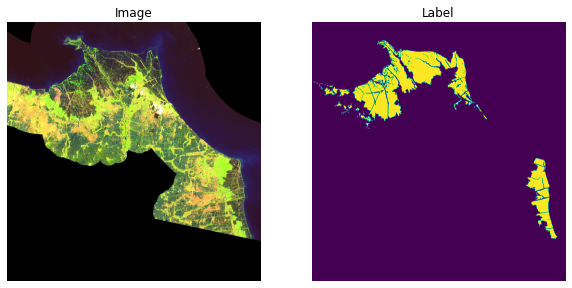

In [219]:
band_composite=(2,1,0)
stretch = True

plot_image_and_label(image_array, lbl_array, band_composite, stretch)

Last, we will look at the mask image. 

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}


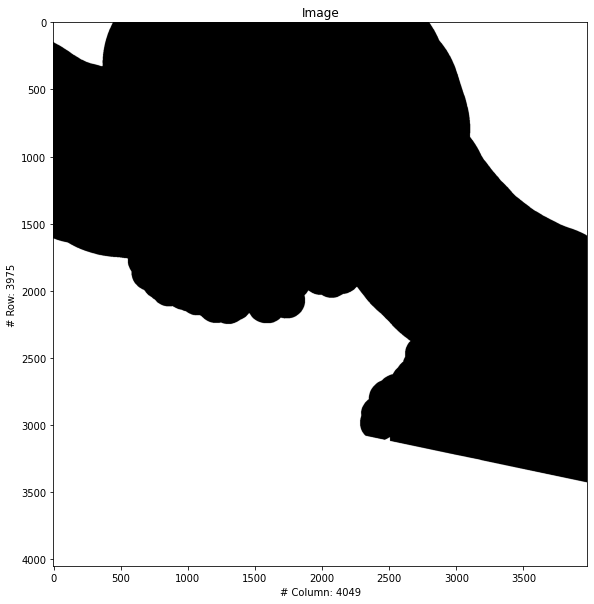

In [220]:
msk_path = os.path.join(src_dir, catalog[catalog.usage=='train']['mask_dir'][0])

with rasterio.open(msk_path) as src:
    print(src.profile)
    msk_array = src.read(1)

plot_image(msk_array, "Greys")

So that's the imagery.  Now we will to move on to examining augmentations. 

#### Test the image processing/augmentation functions

You will want to see--and demonstrate--how the augmentations work, and we will want to see them outside of the data loader that you will be making below.  So, let's run them first.  

##### Normalization

You will need to start by applying image normalization. Run your normalization code here. If you developed one that can clip the tails of the distribution, use that here, and it will be worth an extra 3 points. 

You might want to write a function that simultaneously loads the image and applies the normalization at the same time. You might even want to make it so that the function can differentiate between images and labels. For the images, note that you will have to be careful might have to be careful to run the transpose after normalizing.  
 

###### Optional coding assignment 1 

(3 points)

Modify the min-max input normalization (`min_max_normalize_image`) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image.  (3 points)

To do this, modify the `min_max_normalize_image` function cell below, renaming it `min_max_normalize_image_wclip`. Run it instead of `min_max_normalize_image` when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.



In [221]:
## Modify the normalization function here. Otherwise leave as is.
# def min_max_normalize_image_wclip(...):

#@title Input normalization

def min_max_normalize_image_wclip(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    p1 = np.percentile(image, 1, axis=(1, 2), keepdims=True)
    p99 = np.percentile(image, 99, axis=(1, 2), keepdims=True)

    # Clip the image values to lie within the 1st and 99th percentile range
    clipped_img = np.clip(image, p1, p99)

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(clipped_img, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(clipped_img, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (clipped_img - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

  

###### Load image and apply normalization 

(1 point, with 3 extra if tail-clip normalization is completed)

In [222]:
with rasterio.open(img_path) as src:
  img_np=src.read()
  image_normalized=min_max_normalize_image_wclip(img_np)

###### Plot the normalized image
Show your result here by running the plotting code

In [223]:
band_composite

(2, 1, 0)

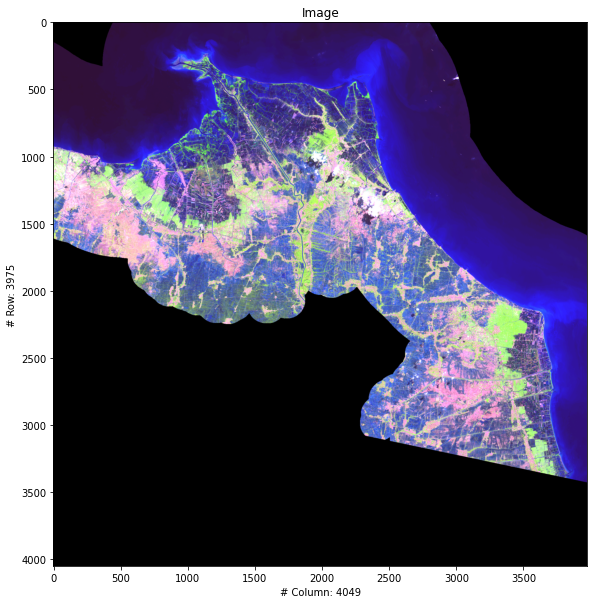

In [224]:
plot_image(image_normalized, band_composite=band_composite, stretch=stretch)

##### Get a chip for testing

(2 points, with 5 extra if optional assignment is completed)

We want to now look at the different augmentations, outside of the data loader.  

This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions. 

You need a few ingredients here: 

- Arguments:
    - patch_size = 256
    - overlap = 32 
    - positive_class_threshold = 0.2
    - crop_ref = [mask, label] 
- You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip. 
- A list `coor` will be needed to catch the indices for x, y, which is the output from `patch_center_index`. 
- A list to catch the image chips, and one to catch the label chips. 
- To get an image chip you need to do something like this:

  ```python
  img_chips = []  # list to catch the chips
  half_win = patch_size // 2  # 1/2 patch size
  # subset image--note the extra dimension for the channel
  img_chips.append(img[x-half_win:x+half_win,   
                       y-half_win:y+half_win, :])
  ```

###### Optional coding assignment 2 

(5 points)

Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process. (5 points)

If you are going to do this, modify the function for getting the center index (call it `get_upperleft_index`) in the cell below. Run it instead of `get_center_index` when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also. 

In [225]:
### Add your indexing function here.  Otherwise leave as is.
#@title Get the center index for chipping
def patch_upperleft_index(crop_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "validate"]

    mask, label = crop_ref

    #half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0])
    x_max = max(x[:, 0]) - patch_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1])
    y_max = max(x[:, 1]) - patch_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):
      

      for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i: i + patch_size, 
                            j: j + patch_size]
            label_ref = label[i: i + patch_size, 
                              j: j + patch_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validate") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "validate":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

###### Apply chipping 

In [226]:
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
crop_ref = [msk_array, lbl_array]

coor=patch_upperleft_index(crop_ref, patch_size, overlap, usage="train", 
                       positive_class_threshold=positive_class_threshold, verbose=True)

Number of patches: 58
Patched from:
[[960, 192], [960, 576], [1152, 576], [768, 768], [960, 768], [1152, 768], [1344, 768], [576, 960], [768, 960], [960, 960], [1152, 960], [1344, 960], [384, 1152], [576, 1152], [768, 1152], [960, 1152], [1152, 1152], [1344, 1152], [384, 1344], [576, 1344], [768, 1344], [960, 1344], [384, 1536], [576, 1536], [768, 1536], [384, 1728], [576, 1728], [768, 1728], [384, 1920], [576, 1920], [384, 2112], [576, 2112], [768, 2112], [960, 2112], [576, 2304], [768, 2304], [960, 2304], [2304, 3264], [2496, 3264], [2112, 3456], [2304, 3456], [2496, 3456], [2688, 3456], [2880, 3456], [2496, 3648], [2688, 3648], [2880, 3648], [3072, 3648], [576, 2688], [2112, 2880], [192, 1920], [1344, 1920], [2880, 3072], [1920, 2880], [960, 2880], [1728, 1920], [1536, 1344], [1920, 1536]]


In [227]:
img_chips = [] # list to catch image chips
lbl_chips=[]  # list to catch label chips
#half_win = patch_size // 2  # 1/2 patch size
# subset image--note the extra dimension for the channel

for i in range(len(coor)):
    img_chips.append(image_array[coor[i][0]:coor[i][0]+patch_size,
                              coor[i][1]:coor[i][1]+patch_size,:])
    lbl_chips.append(lbl_array[coor[i][0]:coor[i][0]+patch_size,
                              coor[i][1]:coor[i][1]+patch_size])

In [ ]:
len(img_chips)

58

In [ ]:
len(lbl_chips)

58

###### Plot your selected chip

Select a single chip by index and then plot it--both the image and label chip.

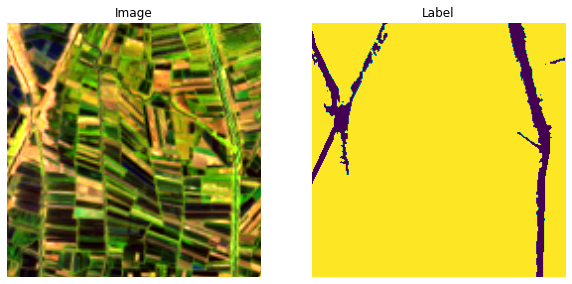

In [228]:
plot_image_and_label(img_chips[10], lbl_chips[10], band_composite, stretch)

##### Augmentation 1

(1 point)

Run your first chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [229]:
### Add your first augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (list of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)
    #center = tuple(np.array(label.shape[:2])/2.0)


    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

###### Apply augmentation 

In [230]:
rotated_img_chips = []
rotated_lbl_chips = []
angle=[30,45,90]
    
for i in range(len(img_chips)):
    img, lbl = rotate_image_and_label(img_chips[i], lbl_chips[i], angle)
    rotated_img_chips.append(img)
    rotated_lbl_chips.append(lbl)
    
    #return rotated_img_chips, rotated_lbl_chips


In [106]:
len(rotated_img_chips[0])

256

###### Plot your augmented chip

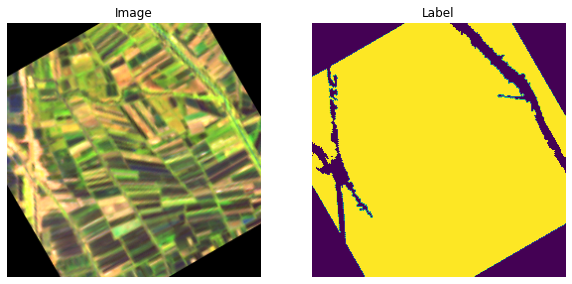

In [231]:
plot_image_and_label(rotated_img_chips[10], rotated_lbl_chips[10], band_composite, stretch)

##### Augmentation 2

(1 point)

Run your second chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [232]:
### Add your second augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is

#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

###### Apply second augmentation 

In [233]:
flipped_img_chips = []
flipped_lbl_chips = []
flip_type='hflip'
    
for i in range(len(rotated_img_chips)):
    img, lbl = flip_image_and_label(img_chips[i], lbl_chips[i], flip_type)
    flipped_img_chips.append(img)
    flipped_lbl_chips.append(lbl)
    
    #return rotated_img_chips, rotated_lbl_chips

###### Plot your augmented chip

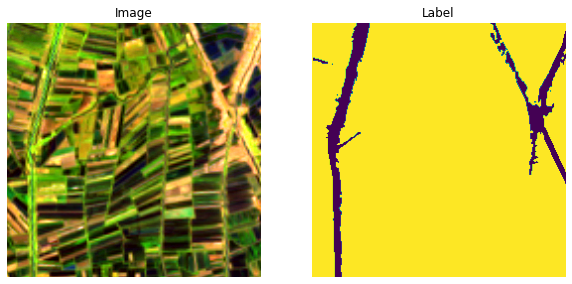

In [234]:
plot_image_and_label(flipped_img_chips[10], flipped_lbl_chips[10], band_composite, stretch)

#### Create and demonstrate your loader

(15 points)

##### Create your loader
(10 points)

Adapt the template below to create your custom data loader. 

In [235]:
class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap, 
                 positive_class_threshold = 0.15, apply_normalization=True, 
                 transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_name (str) : Name of the csv file containing the input paths.
        usage (str) : Either 'train' or 'validation'.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : Amount of overlap (in pixels) between extracted chips.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
        transform (list) -- Each element is string name of the transformation to
             be used, e.g. ["rotate", "flip"]
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.overlap = overlap
        self.positive_class_threshold=positive_class_threshold
        self.transform = transform
        
        self.usage = usage
        assert self.usage in ["train", "validate"], "Usage is not recognized."

        self.patch_size = patch_size
        half_size = patch_size // 2

        catalog = pd.read_csv(Path(src_dir) / csv_name)
        self.catalog = catalog[catalog.usage==self.usage]

        self.img_chips = []
        self.lbl_chips = []
        self.coor = []

        if self.usage == "train":
          img_path =  os.path.join(src_dir, self.catalog['img_dir'][0])
          lbl_path =  os.path.join(src_dir, self.catalog['label_dir'][0])
          mask_path = os.path.join(src_dir, self.catalog['mask_dir'][0])

        if self.usage == "validate":
          img_path =  os.path.join(src_dir, self.catalog['img_dir'][1])
          lbl_path =  os.path.join(src_dir, self.catalog['label_dir'][1])
          mask_path = os.path.join(src_dir, self.catalog['mask_dir'][1])

        print(img_path)
        print(lbl_path)

        #your code to load the image from img_path and make sure channel 
               # is the last dimension. Make sure to apply the transformation
        with rasterio.open(img_path) as src:
          img=src.read()
        #your code to load the label from lbl_path
        with rasterio.open(lbl_path) as src:
          lbl=src.read(1)
        #your code to load the mask from mask_path
        with rasterio.open(mask_path) as src:
          mask=src.read(1)

        # print(mask)
        # img =  os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])

        crop_ref = [mask, lbl]

        # call the chipping function with the proper arguments
        if apply_normalization==True:
          img=min_max_normalize_image_wclip(img)
        
        img=np.transpose(img,(1,2,0))


        index = patch_upperleft_index(crop_ref, patch_size, overlap, usage, 
                       positive_class_threshold, verbose=True)
        

        for i in range(len(index)):
            x = index[i][0]
            y = index[i][1]

            self.coor.append([x, y])
            #Use the x, y coordinates of the center indices to chip through the 
            # image and label and add each chip to its corresponding list. You 
            # need to properly index through the three dimensions of the image
            # and two dimensions of the label.
            self.img_chips.append(img[x:x+patch_size, y:y+patch_size,:]) #your code here
            self.lbl_chips.append(lbl[x:x+patch_size, y:y+patch_size]) #your code here

            
        msg = '--------------{} patches cropped--------------'
        print(msg.format(len(self.img_chips)))
        

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        if self.usage == "train" and transform:

            # revise lines 84-88 to add your augmentation of choice
            # if applying flipping, make sure that the flip direction is 
            # randomly chosen also, which can be achieved using random choice 
            # from a list of the two directions.  
            if "flip" in transform:
              flip_types=["hflip","vflip"]
              flip_direction=flip_types[random.randint(0,1)]
              image_chip, label_chip = flip_image_and_label(image_chip, label_chip, flip_type=flip_direction)                                        

            if "rotate" in transform:
              image_chip, label_chip = rotate_image_and_label(image_chip,label_chip,angle=[(random.random()<0.5)*360,(random.random()<0.5)*360])
                                                                  
        # Convert numpy arrays to torch tensors.
        # Image chips should be: CHW if not transpose to correct order of 
        # dimensions.

        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()
      
        #return image_chip, label_chip
        #print(image_chip)
        return image_tensor, label_tensor

    def __len__(self):

        return len(img_chips)
        #put your code here (this needs to count the number of chips)

##### Demonstrate your loader
(5 points) 

Use/adapt the following arguments to run code. 

In [236]:

src_dir = "/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
apply_normalization = True
transform = ['flip'] # fill list with your transforms


###### Training dataset

In [237]:
train_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization, transform
)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data/clip_tile_121_64/bands/comp456_2014_clip_121_64.rst
/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data/clip_tile_121_64/label/ponds_2014_clip_121_64.rst
Number of patches: 58
Patched from:
[[960, 192], [960, 576], [1152, 576], [768, 768], [960, 768], [1152, 768], [1344, 768], [576, 960], [768, 960], [960, 960], [1152, 960], [1344, 960], [384, 1152], [576, 1152], [768, 1152], [960, 1152], [1152, 1152], [1344, 1152], [384, 1344], [576, 1344], [768, 1344], [960, 1344], [384, 1536], [576, 1536], [768, 1536], [384, 1728], [576, 1728], [768, 1728], [384, 1920], [576, 1920], [384, 2112], [576, 2112], [768, 2112], [960, 2112], [576, 2304], [768, 2304], [960, 2304], [2304, 3264], [2496, 3264], [2112, 3456], [2304, 3456], [2496, 3456], [2688, 3456], [2880, 3456], [2496, 3648], [2688, 3648], [2880, 3648], [3072, 3648], [1728, 2496], [192, 384], [1728, 960], [192, 1728], [1344, 3072], [1728, 3072], [1920, 2880], [576, 2688], [1920, 2688], 

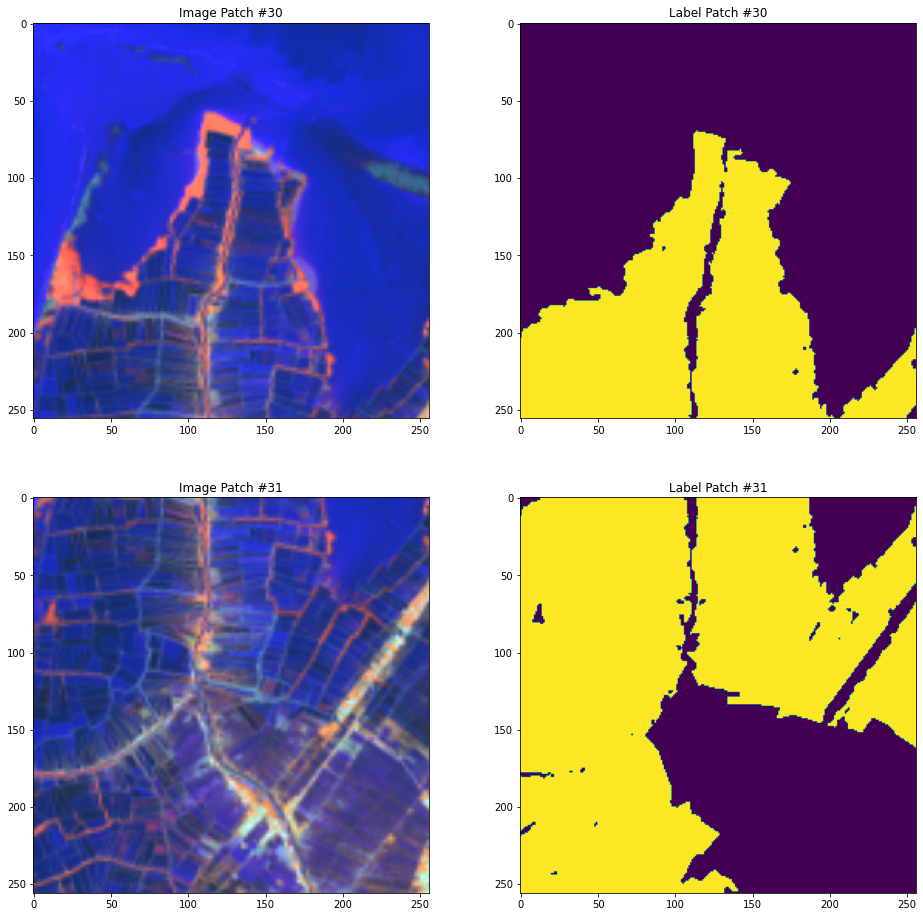

In [207]:
show_random_patches(train_dataset, sample_num=2, rgb_bands=(0, 1, 2))

###### Validation dataset

In [246]:
src_dir = "/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data"
csv_name = "pond_scenes_train_val.csv"
usage = "validate"
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
apply_normalization = True
transform = ['flip'] # fill list with your transforms

In [247]:
validate_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization=False, transform=None
)
validate_loader = DataLoader(validate_dataset, batch_size = 4, shuffle = True)


/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data/clip_tile_122_64/bands/comp456_2014_clip_122_64.rst
/content/drive/My Drive/Clark/Deep_Learning/Lab 3/Data/clip_tile_122_64/label/ponds_2014_clip_122_64.rst
Number of patches: 123
Patched from:
[[2893, 0], [3085, 0], [3277, 0], [1741, 192], [1933, 192], [2317, 192], [2509, 192], [2701, 192], [2893, 192], [3085, 192], [3277, 192], [1741, 384], [1933, 384], [2125, 384], [2317, 384], [2509, 384], [2701, 384], [2893, 384], [3085, 384], [3277, 384], [1741, 576], [1933, 576], [2125, 576], [2317, 576], [2509, 576], [2701, 576], [2893, 576], [3085, 576], [1741, 768], [1933, 768], [2125, 768], [2317, 768], [2509, 768], [2701, 768], [2893, 768], [1741, 960], [1933, 960], [2125, 960], [2317, 960], [2509, 960], [1933, 1152], [2125, 1152], [2317, 1152], [2125, 1344], [2317, 1344], [2509, 1344], [2125, 1536], [2317, 1536], [2509, 1536], [2125, 1728], [2317, 1728], [2509, 1728], [2125, 1920], [2317, 1920], [2509, 1920], [2125, 2112], [2317, 2112]

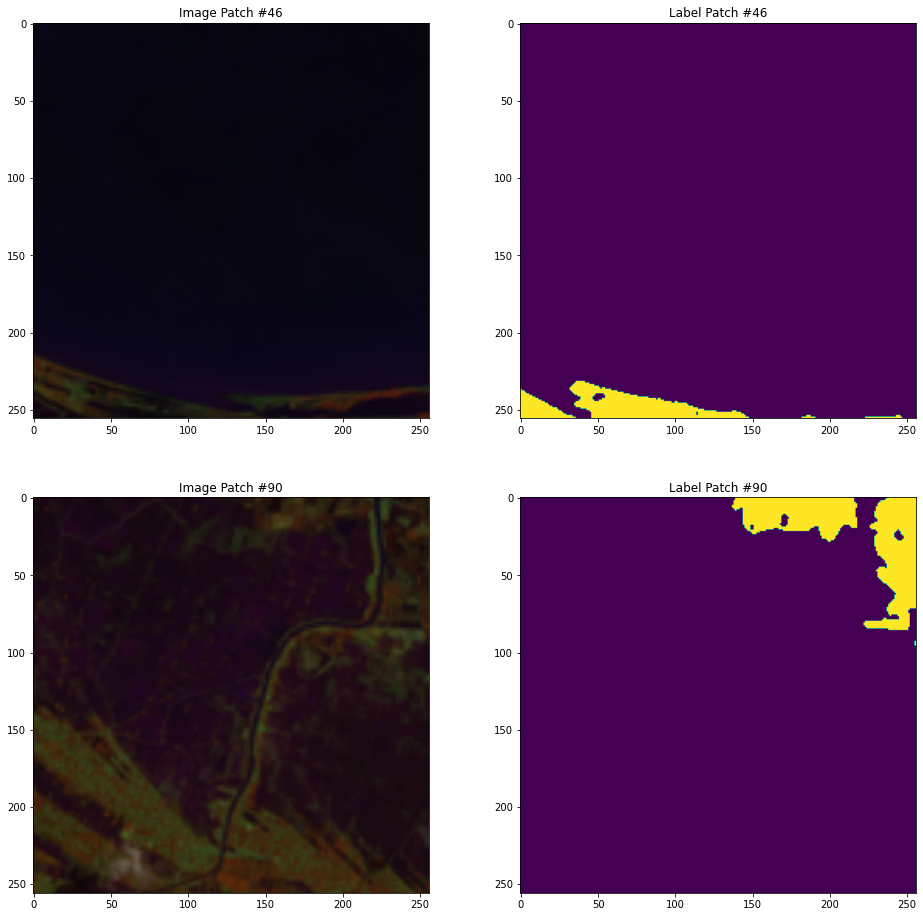

In [248]:
show_random_patches(validate_dataset, sample_num=2, rgb_bands=(0, 1, 2))